In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [4]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### PREPROCESSING

In [7]:
train_df.drop(['PassengerId','Cabin','Name','Ticket'], axis=1, inplace=True)
test_df.drop(['PassengerId','Cabin','Name','Ticket'], axis=1, inplace=True)

<AxesSubplot:>

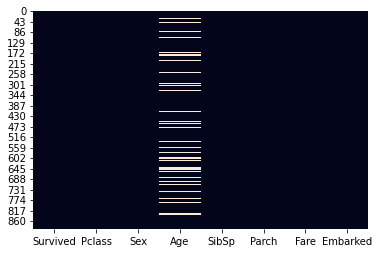

In [8]:
sns.heatmap(train_df.isnull(), cbar = False)

In [9]:
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [10]:
train_df['Age'].fillna(train_df['Age'].mean(), inplace = True)

In [11]:
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace = True)

In [12]:
train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked'], drop_first=True)
test_df = pd.get_dummies(data=test_df, columns=['Sex', 'Embarked'],drop_first=True)

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Sex_male    891 non-null    uint8  
 7   Embarked_Q  891 non-null    uint8  
 8   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 44.5 KB


### EDA

In [14]:
train_df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Survived', ylabel='count'>

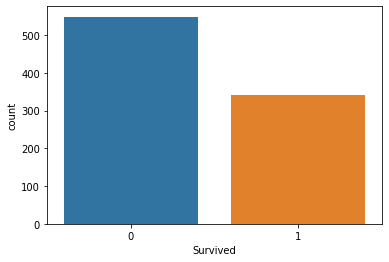

In [15]:
sns.countplot('Survived', data = train_df)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sex_male', ylabel='count'>

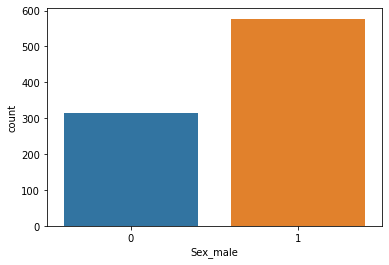

In [16]:
sns.countplot('Sex_male', data = train_df)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Sex_male', ylabel='count'>

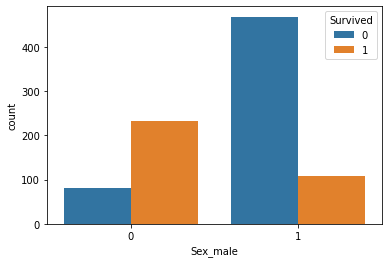

In [17]:
sns.countplot('Sex_male', hue='Survived', data=train_df)

### MODEL

In [18]:
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']
X_test = test_df.copy()

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=2, shuffle=True)

In [20]:
categorical_features = ['Pclass', 'Sex_male', 'SibSp', 'Parch', 'Embarked_Q', 'Embarked_S']
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train,categorical_feature=categorical_features)

In [21]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params={
    'num_leaves':100,
    'objective':'binary',
    'max_depth':5,
    'learning_rate':.05,
    'early_stopping_rounds':15,
    'n_estimators':40000000
}
num_round=1000

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval], num_boost_round=num_round, categorical_feature=categorical_features)

[LightGBM] [Info] Number of positive: 263, number of negative: 449
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 213
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369382 -> initscore=-0.534869
[LightGBM] [Info] Start training from score -0.534869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's binary_logloss: 0.634708	valid_1's binary_logloss: 0.676492
Training until validation scores don't improve for 15 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's binary_logloss: 0.613355	valid_1's binary_logloss: 0.65791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training

In [24]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred > 0.5).astype(int)

In [26]:
final = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
final['Survived'] = list(map(int, Y_pred))
final.to_csv('submission.csv', index=False)